In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

%matplotlib inline

## Data Cleaning and Preprocessing

First we load in the Data 

In [2]:
bike_data = pd.read_csv('bike_clean.csv')
collisions_data = pd.read_csv('data/Traffic_Collision_Data_from_2010_to_Present.csv')

In [3]:
newBike_data = bike_data

Convert all date data to Pandas Datatime objects

In [4]:
# CAN TAKE OUT!!!!!

bike_data['start_time'] = pd.to_datetime(bike_data['start_time'])
bike_data['end_time'] = pd.to_datetime(bike_data['end_time'])

In [6]:
collisions_data['Date Occurred'] = pd.to_datetime(collisions_data['Date Occurred'])
collisions_data = collisions_data[collisions_data['Date Occurred'].dt.date >= bike_data['start_time'].dt.date.min()]
collisions_data = collisions_data[collisions_data['Date Occurred'].dt.date <= bike_data['start_time'].dt.date.max()]
collisions_data = collisions_data.reset_index()

# Bike Dock Data Vs. Traffic Collisions

Now we need to pull out the longitude and latitude values which are now in tuples in our data.  Below are functions to do that!

In [7]:
def createLat(coordinates):
    try: 
        coordinates.strip()
        coordinates = coordinates.replace('(','')
        coordinates = coordinates.replace(')','')
        lat, lon = coordinates.split(', ')
        return float(lat) 
    except:
        return np.nan

def createLon(coordinates):
    try: 
        coordinates.strip()
        coordinates = coordinates.replace('(','')
        coordinates = coordinates.replace(')','')
        lat, lon = coordinates.split(', ')
        return float(lon) 
    except:
        return np.nan

Now we apply the functions and add columns to our data

In [8]:
newBike_data["start_latitude"] = newBike_data["start_lat_lon"].apply(createLat)
newBike_data["start_longitude"] = newBike_data["start_lat_lon"].apply(createLon)
newBike_data["end_latitude"] = newBike_data["end_lat_lon"].apply(createLat)
newBike_data["end_longitude"] = newBike_data["end_lat_lon"].apply(createLon)

In [9]:
collisions_data["latitude"] = collisions_data["Location"].apply(createLat)
collisions_data["longitude"] = collisions_data["Location"].apply(createLon)

Next we drop some columns to simplify the data

In [10]:
collisions_data = collisions_data.drop(columns=['Location', 'Cross Street', 'Address', 'Premise Code', 'Victim Descent', 'MO Codes', 'Reporting District', 'Crime Code', 'Area ID'])

In [11]:
newBike_data = newBike_data.drop(columns=['weather', 'humidity', 'windspeed', 'temperature','passholder_type','estimated_fare','bike_type','start_lat_lon','end_lat_lon'])

## Prepare for Visualizations

First, we drop nan and zero values in longitude and latitude all of the data

In [12]:
newBike_data.dropna(subset=['start_latitude','start_longitude','end_latitude','end_longitude'], inplace=True)
newBike_data = newBike_data.loc[(newBike_data['start_latitude'] != 0) & (newBike_data['start_longitude'] != 0) & (newBike_data['end_latitude'] != 0) & (newBike_data['end_longitude'] != 0)]
collisions_data = collisions_data.loc[(collisions_data['latitude'] != 0) & (collisions_data['longitude'] != 0)]

Now we create the Coordinate Reference system

In [13]:
crs = {'init': 'epsg:4326'}

Next, we create points for each dataset  
Definition: A point is an object that describes the Longitude and Latitude of a data point

In [14]:
geometry_collisions = [Point(xy) for xy in zip(collisions_data["longitude"], collisions_data["latitude"])]
geometry_start = [Point(xy) for xy in zip(newBike_data["start_longitude"], newBike_data["start_latitude"])]
geometry_end = [Point(xy) for xy in zip(newBike_data["end_longitude"], newBike_data["end_latitude"])]

Now we create new data frames with the point data 

In [15]:
bikestart_geo = gpd.GeoDataFrame(newBike_data, crs=crs, geometry=geometry_start)
bikeend_geo = gpd.GeoDataFrame(newBike_data, crs=crs, geometry=geometry_end)
collisions_geo = gpd.GeoDataFrame(collisions_data, crs=crs, geometry=geometry_collisions)

# Visualizations 

#### Here we will visually explore collision and bike dock data throughout Los Angeles and see if we can gain some insight

First, we load a Shape File of Los Angeles Streets 

In [16]:
mapLA = gpd.read_file('data/tl_2014_06037_roads.shp')

Let's plot both collisions and the bike doc locations for all of LA

(-118.7, -118.1)

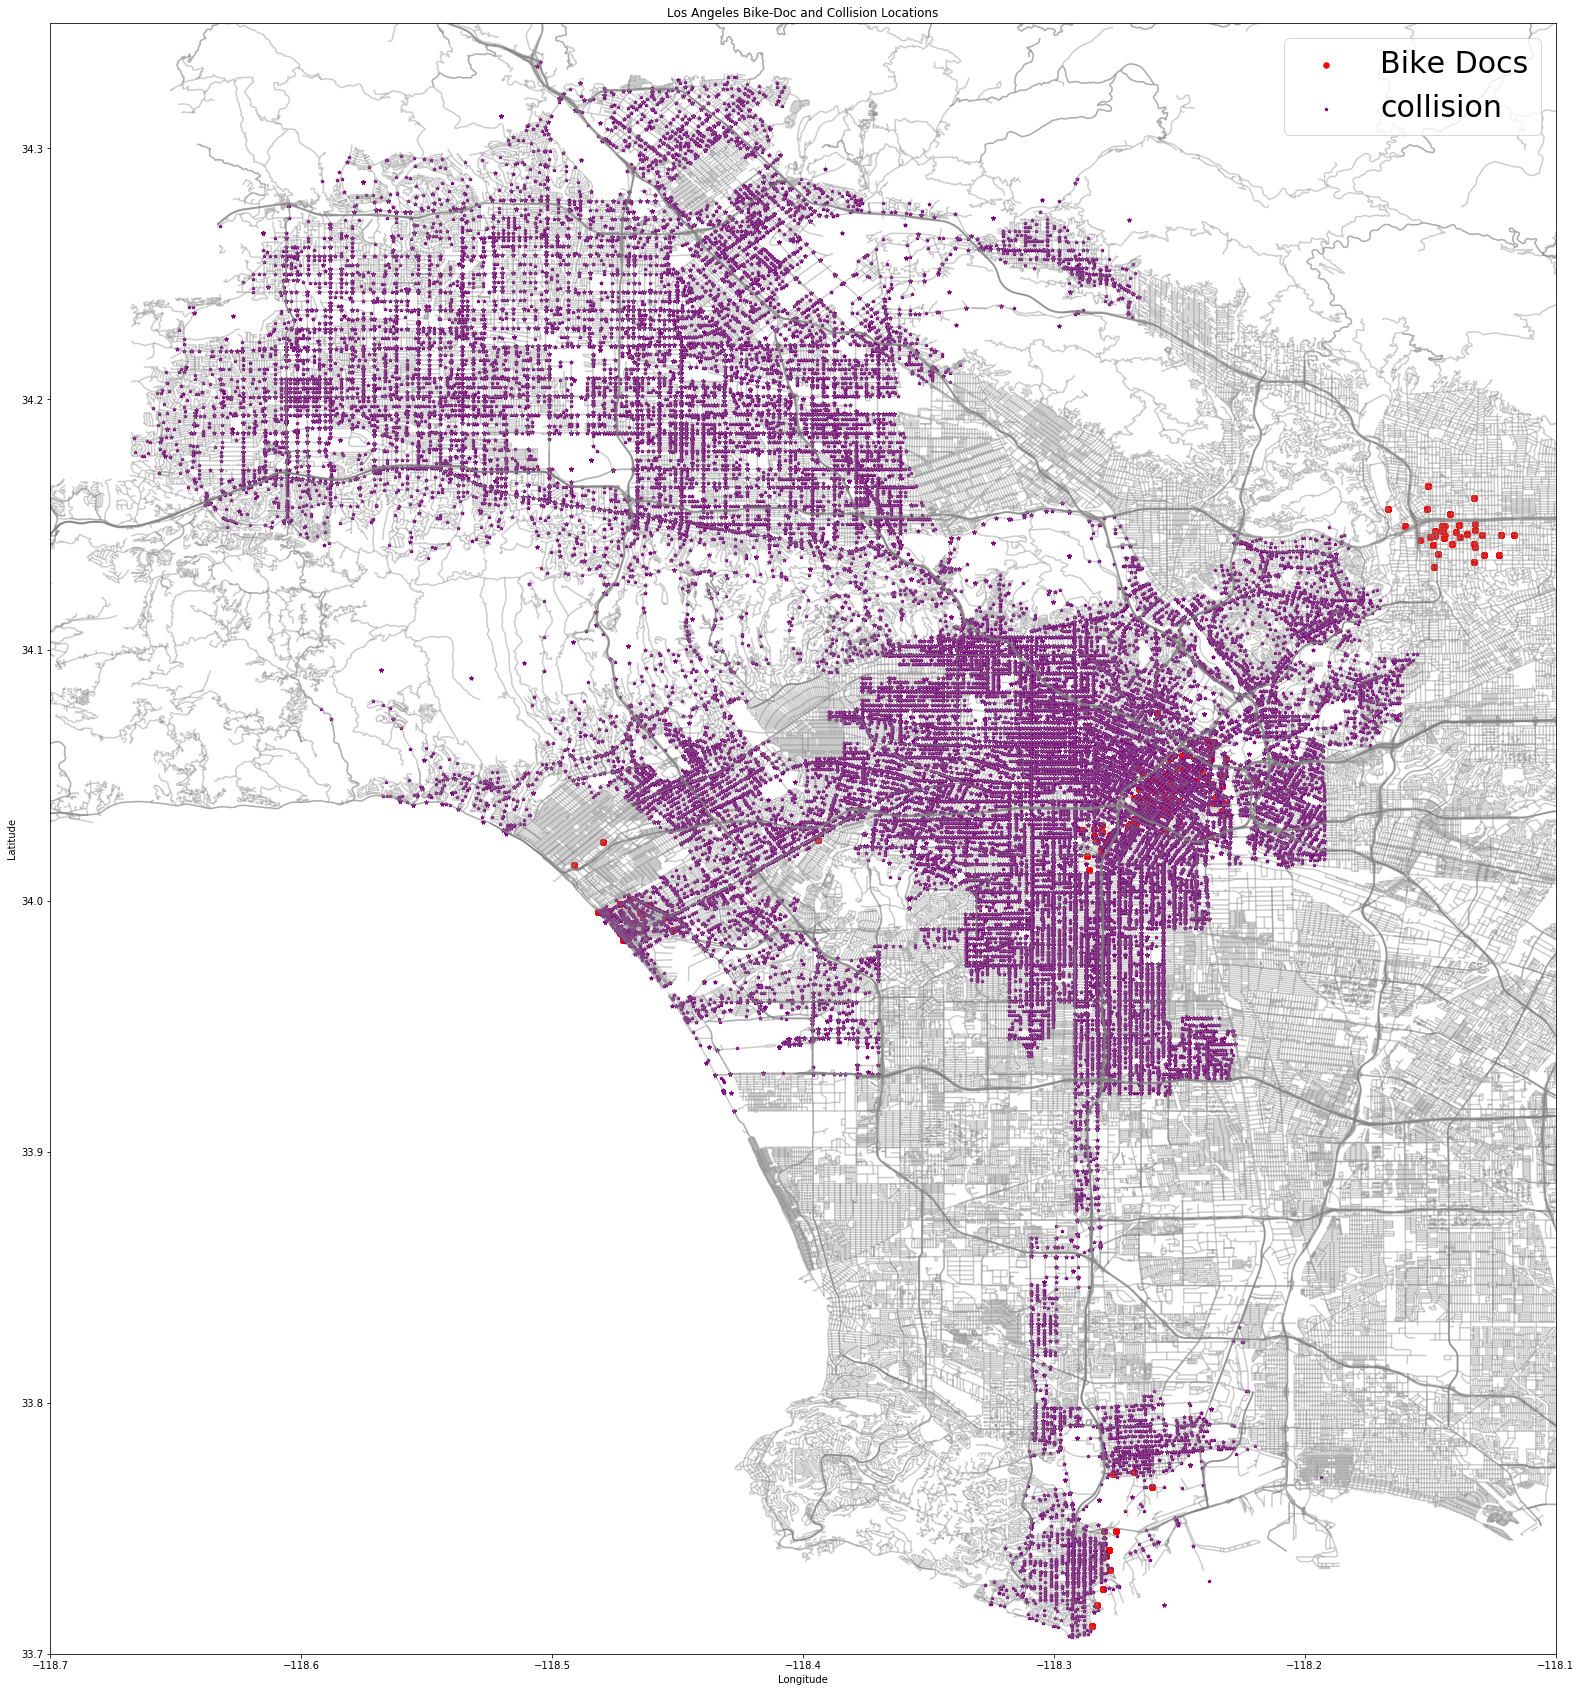

In [17]:
fig, ax = plt.subplots(figsize=(30,30))
mapLA.plot(ax=ax, alpha=0.4, color='grey')

bikeend_geo.plot(ax=ax, markersize=30, color='red', marker='o', label='Bike Docs')
collisions_geo.plot(ax=ax, markersize=10, color='purple', marker='*', label='collision')
plt.legend(prop={'size': 30})
plt.title('Los Angeles Bike-Doc and Collision Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.ylim(33.7, 34.35) 
plt.xlim(-118.7, -118.1) 

There are few interesting points that arise from this visualization:
1. We bike doc data for Pasadena (In the top right corner) but no collision data
2. There are four large nodes for the bike doc data: Downtown LA, Santa Monica, Long Beach, and Pasadena

Downtown looks like it has the most collisions and has docs for the bikes, let's look at the downtown bike doc locations

(-118.31, -118.2)

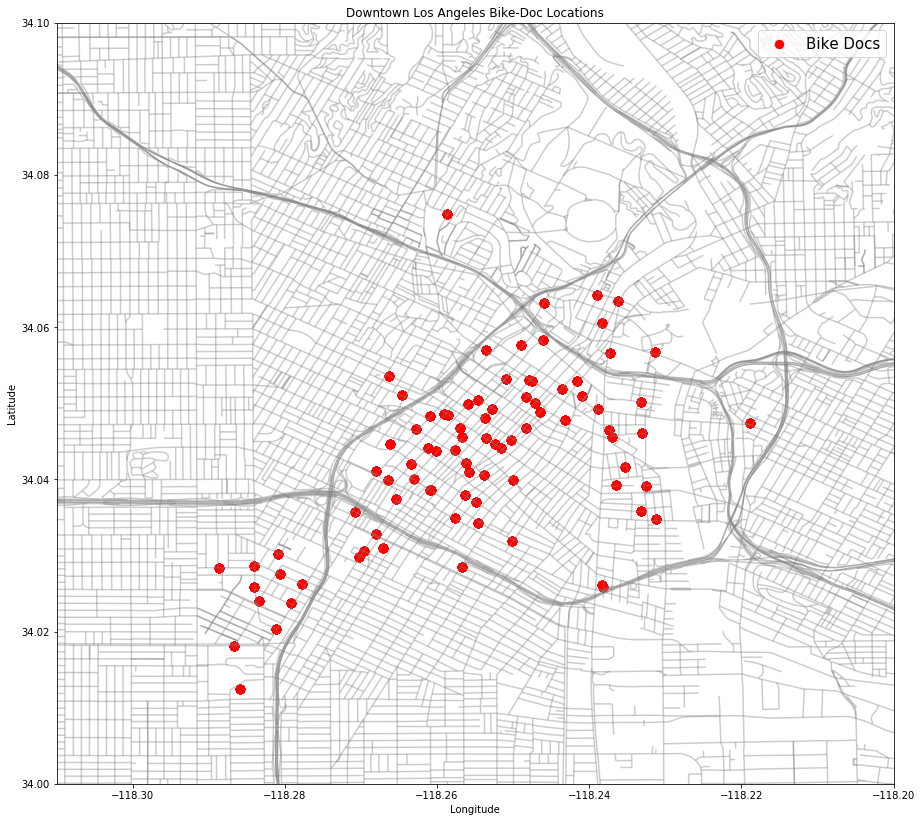

In [18]:
fig, ax = plt.subplots(figsize=(15,15))
mapLA.plot(ax=ax, alpha=0.4, color='grey')

bikestart_geo.plot(ax=ax, markersize=70, color='red', marker='o', label='Bike Docs')
plt.legend(prop={'size': 15})
plt.title('Downtown Los Angeles Bike-Doc Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.ylim(34, 34.1) 
plt.xlim(-118.31, -118.2) 

It's important to note that these are locations of the actual docks for the bike, that means that people can be riding the bikes all throughout this area

Let's now overlay the collisions and see what we can gather

(-118.3, -118.21)

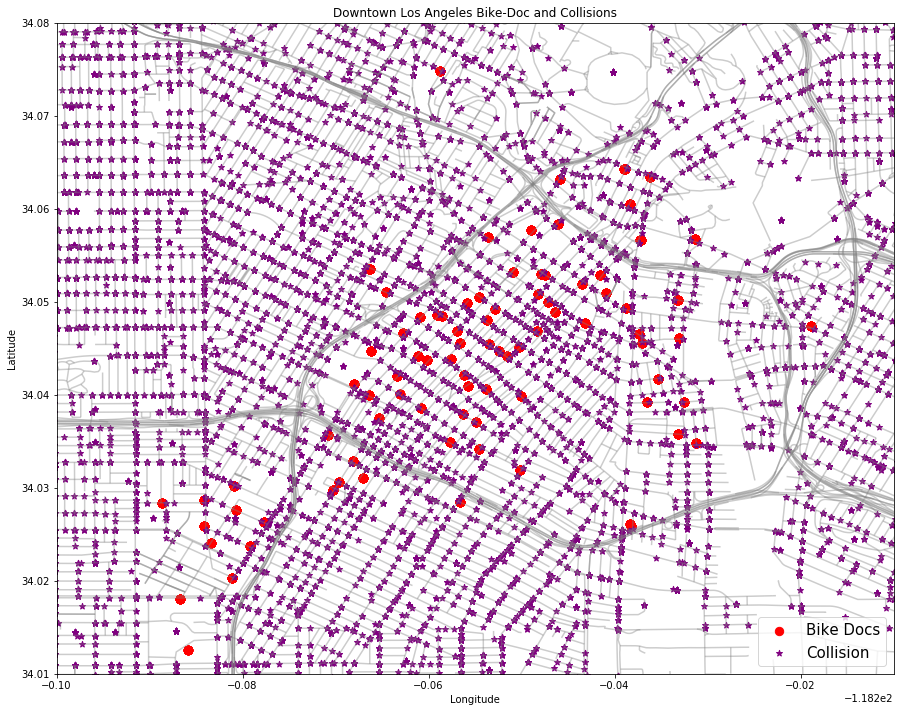

In [19]:
fig, ax = plt.subplots(figsize=(15,15))
mapLA.plot(ax=ax, alpha=0.4, color='grey')

bikestart_geo.plot(ax=ax, markersize=70, color='red', marker='o', label='Bike Docs')
collisions_geo.plot(ax=ax, markersize=40, color='purple', marker='*', label='Collision')
plt.legend(prop={'size': 15})
plt.title('Downtown Los Angeles Bike-Doc and Collisions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.ylim(34.01, 34.08) 
plt.xlim(-118.3, -118.21) 

There is a collision on practically every street, let's keep digging

Let's segment data to just our downtown visualization 

In [20]:
collisions_downtown = collisions_data.loc[(collisions_data['latitude'] <= 34.08) & (collisions_data['latitude'] >= 34.01) & (collisions_data['longitude'] <= -118.21) & (collisions_data['longitude'] >= -118.3)]

In [21]:
bikes_downtown = newBike_data.loc[(newBike_data['start_latitude'] <= 34.08) & (newBike_data['start_latitude'] >= 34.01) & (newBike_data['start_longitude'] <= -118.21) & (newBike_data['start_longitude'] >= -118.3)]

Let's look at the number of collisions and bike rentals 

In [22]:
collision_d1 = len(collisions_downtown)
bike_d1 = len(bikes_downtown)

In [23]:
print(bike_d1, collision_d1)

495176 22209


So we have much more bike rentals than collisions for within the same dates downtown.    
That is good news, but doesn't provide any clue as to if they are related.    
Let's dig deeper.

#### Now we will check another portion of downtown without bike docs to compare.    
We will take the same area as the downtown visualization above for consistency - Each map is 0.7 X 0.7 Degrees.  

(-118.35, -118.28)

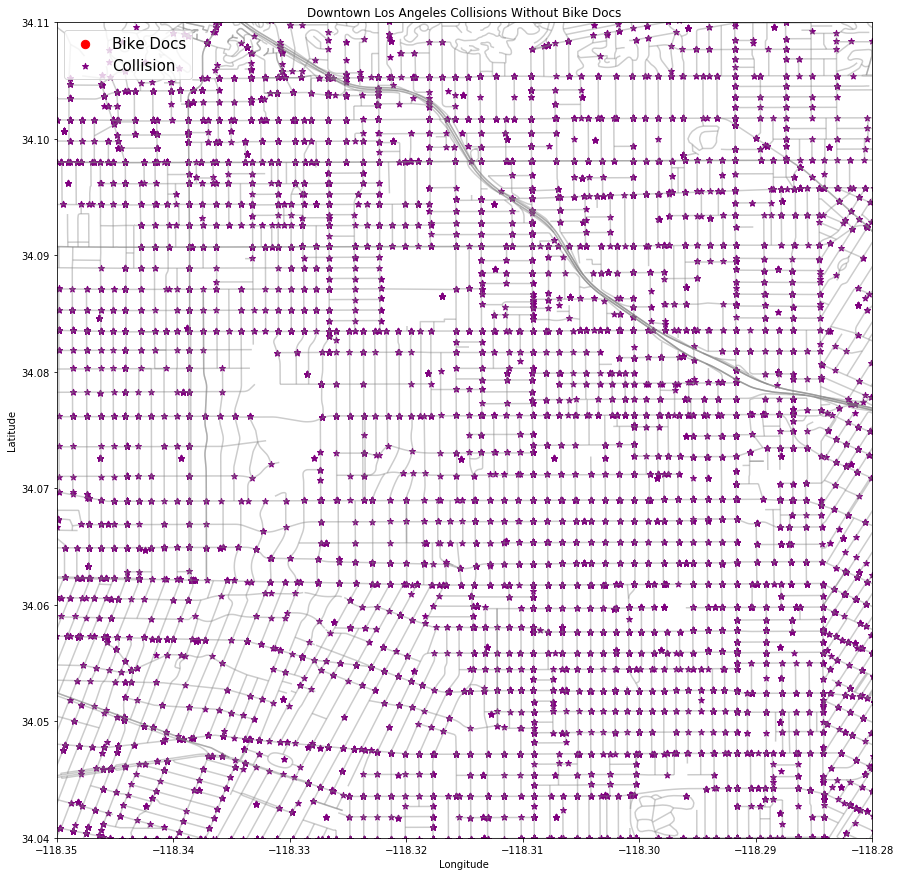

In [24]:
fig, ax = plt.subplots(figsize=(15,15))
mapLA.plot(ax=ax, alpha=0.4, color='grey')

bikestart_geo.plot(ax=ax, markersize=70, color='red', marker='o', label='Bike Docs')
collisions_geo.plot(ax=ax, markersize=40, color='purple', marker='*', label='Collision')
plt.legend(prop={'size': 15})
plt.title('Downtown Los Angeles Collisions Without Bike Docs')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.ylim(34.04, 34.11) 
plt.xlim(-118.35, -118.28) 

Awesome, Let's look at how many collisions there are:

In [25]:
collision_d2 = len(collisions_data.loc[(collisions_data['latitude'] <= 34.11) & (collisions_data['latitude'] >= 34.04) & (collisions_data['longitude'] <= -118.28) & (collisions_data['longitude'] >= -118.35)])

In [26]:
print(collision_d2)

18795


Interesting, we have less collisions.  
A couple explanations:  
1. This is just notheast of the downtown with bike docs and the streets aren't as dense, this may contribute to our results.
2. We aren't even acounting for individual bikers
3. We aren't considering the people who have taken there dockable bike to this location.  

#### Now let's look at the dockable bikes in Santa Monica

Let's Look at both the bike dock locations and collisions for the same size area in Santa Monica

(-118.48, -118.41)

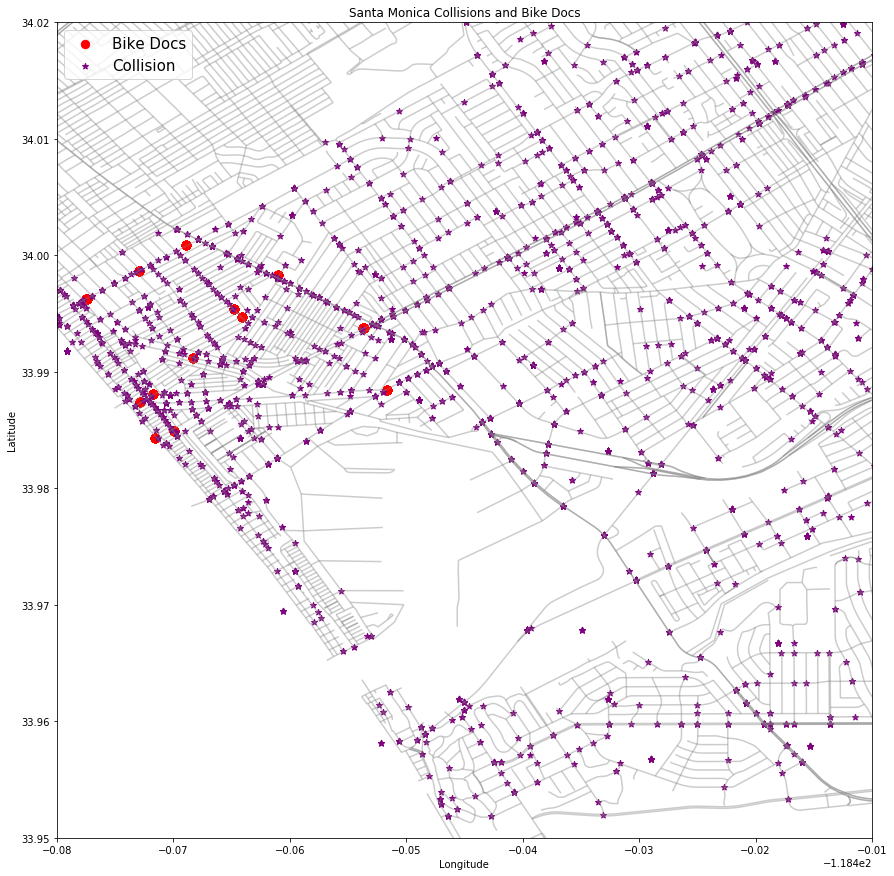

In [27]:
fig, ax = plt.subplots(figsize=(15,15))
mapLA.plot(ax=ax, alpha=0.4, color='grey')

bikestart_geo.plot(ax=ax, markersize=70, color='red', marker='o', label='Bike Docs')
collisions_geo.plot(ax=ax, markersize=40, color='purple', marker='*', label='Collision')
plt.legend(prop={'size': 15})
plt.title('Santa Monica Collisions and Bike Docs')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.ylim(33.95, 34.02) 
plt.xlim(-118.48, -118.41) 

Awesome! Let's look at the number of bike rentals and collisions

In [28]:
collision_sm1 = len(collisions_data.loc[(collisions_data['latitude'] <= 34.02) & (collisions_data['latitude'] >= 33.95) & (collisions_data['longitude'] <= -118.41) & (collisions_data['longitude'] >= -118.48)])
bike_sm1 = len(newBike_data.loc[(newBike_data['start_latitude'] <= 34.02) & (newBike_data['start_latitude'] >= 33.95) & (newBike_data['start_longitude'] <= -118.41) & (newBike_data['start_longitude'] >= -118.48)])

In [29]:
print(collision_sm1, bike_sm1)

3708 44997


Okay, so we have much less bike rentals and collisions.  
A couple explanations:  
1. The streets are much wider
2. This area is definitely less dense then downtown - this could be an outlying factor in collisions
3. Less people in general are in Santa Monica
4. The number of bike rentals and collisions are directly proportional (from downton to Santa Monica), but this is completely ignoring other factors

#### Let's find another place in Santa Monica without the Bike Docs

(-118.45, -118.38)

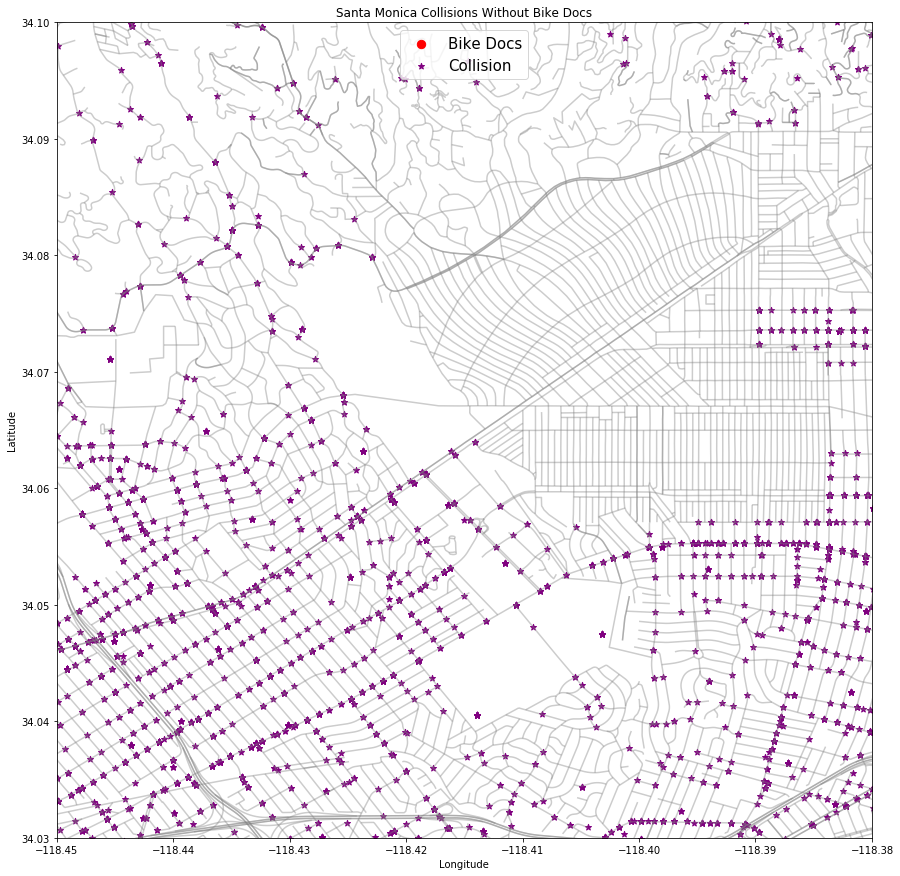

In [30]:
fig, ax = plt.subplots(figsize=(15,15))
mapLA.plot(ax=ax, alpha=0.4, color='grey')

bikestart_geo.plot(ax=ax, markersize=70, color='red', marker='o', label='Bike Docs')
collisions_geo.plot(ax=ax, markersize=40, color='purple', marker='*', label='Collision')
plt.legend(prop={'size': 15})
plt.title('Santa Monica Collisions Without Bike Docs')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.ylim(34.03, 34.1) 
plt.xlim(-118.45, -118.38) 

Great, let's see the number of collisions

In [31]:
collision_sm2 = len(collisions_data.loc[(collisions_data['latitude'] <= 34.1) & (collisions_data['latitude'] >= 34.03) & (collisions_data['longitude'] <= -118.38) & (collisions_data['longitude'] >= -118.45)])

In [32]:
print(collision_sm2)

4130


Okay, so we have more collisions here than the location with the bike docks.
This visualization is northeast of the previous visualization.    
More things to note:
1. There is no way to tell if we have the same amount of roads in this graph 
2. We don't know the amenities present here, such as shops, bussinesses, or density of streets

## Analysis of Map Data

Let's look further into the counts we found and see if we can find anything interesting

In [33]:
print("Bike Rentals Downtown: ", bike_d1) 
print("Collisions Downtown: ", collision_d1)
print("Other Collisions Downtown: ", collision_d2)
print("Bike Rentals Santa Monica: ", bike_sm1)
print("Collisions Santa Monica: ", collision_sm1)
print("Other Collisons Santa Monica: ", collision_sm2)

Bike Rentals Downtown:  495176
Collisions Downtown:  22209
Other Collisions Downtown:  18795
Bike Rentals Santa Monica:  44997
Collisions Santa Monica:  3708
Other Collisons Santa Monica:  4130


Nice! Let's look at the totals:

In [34]:
total_bike = bike_d1+bike_sm1
total_bike

540173

In [35]:
total_collision = collision_sm1+collision_d1
total_collision

25917

In [36]:
collision_d2 + collision_sm2

22925

Okay, so we have less collisions in the areas without the bike docs, interesting

Let's look at the ratio of bike rentals to collisions 

In [37]:
bike_d1/collision_d1

22.29618623080733

In [38]:
bike_sm1/collision_sm1

12.135113268608414

In [39]:
total_bike/total_collision

20.842420033182854

Okay, so downtown has 22 times the bike rentals than collisions and Santa Monica has 12 times the number of bike rentals to traffic collisions.  Together we have 21 time the bike rentals
A couple things to note:
1. The downtown data skews the Santa Monica Data
2. More people are active and downtown in general, this provides much more opportunities and factors thay may contriute to collisions
3. Less bikes are having a bigger impact in Santa Monica, maybe bikes are more impactful there

#### Let's dig deeper and do some statistical analysis

## Explore Downtown Data

#### Let's explore the counts of bikes and collisons based on the day 
First, we create two pandas series of the counts of collisions and bike rentals per day

In [40]:
counts_bike = bikes_downtown['start_time'].groupby([bikes_downtown['start_time'].dt.date]).count()
counts_collisions = collisions_downtown['Date Occurred'].groupby([collisions_downtown['Date Occurred'].dt.date]).count()

Let's create a new dataframe with counts, and dates

In [41]:
combined_counts = pd.concat([counts_bike, counts_collisions], axis=1)

In [42]:
combined_counts = combined_counts.reset_index(level=0)
combined_counts.columns = ['Date','Bike_Usage_Counts', 'Traffic_Collision_Counts']

In [43]:
combined_counts.head()

Date  Bike_Usage_Counts  Traffic_Collision_Counts
0  2016-07-07                190                        21
1  2016-07-08                344                        17
2  2016-07-09                421                        25
3  2016-07-10                334                        21
4  2016-07-11                349                        20

Perfect, Let's visualize

#### Checkout the Traffic collision counts by date

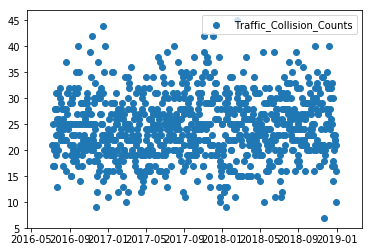

In [44]:
plt.scatter(combined_counts['Date'],combined_counts['Traffic_Collision_Counts'])
plt.legend()

We have relatively consistent collisions per day ranging from around 20 to 60 starting on 07/07/2016 and ending on 12/31/2018

#### Checkout the Bike rental counts by date

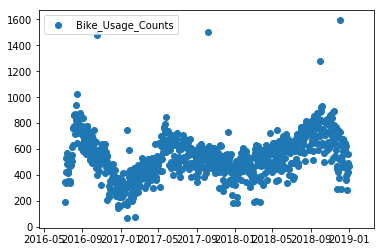

In [45]:
plt.scatter(combined_counts['Date'], combined_counts['Bike_Usage_Counts'])
plt.legend()

Okay, so the rentals drop up and down depending on the season and definitely have some outliers.  It looks like they have some high areas that are together, but that may be the result of a sunny day or event occuring.    
It is hard to tell weather the each of these counts (collisions and rental rates) are aligning together by date.  Let's go even deeper. 

## Statistical Analysis of Collision and Bike Rental rates

Let's see how correlated the usage counts are:

In [46]:
combined_counts.corr()

Bike_Usage_Counts  Traffic_Collision_Counts
Bike_Usage_Counts                  1.000000                  0.230508
Traffic_Collision_Counts           0.230508                  1.000000

So 0.224698 is a relatively small number, but is nowhere near 1, or fully correlated.    
Let's keep looking

### Design Matrix!

Now, we create the design matrix comparing Collisions and Bike Rentals

In [47]:
outcome_2, predictors_2 = patsy.dmatrices('Bike_Usage_Counts ~ Traffic_Collision_Counts', combined_counts)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:      Bike_Usage_Counts   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     50.84
Date:                Mon, 18 Mar 2019   Prob (F-statistic):           2.05e-12
Time:                        14:03:32   Log-Likelihood:                -5880.6
No. Observations:                 908   AIC:                         1.177e+04
Df Residuals:                     906   BIC:                         1.177e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Okay, so here we have a P>|t| of 0.00! That means that they are significantly different, or in other words, do not correlate.  

### T-test!

Now, let's do a T test on the two values

In [48]:
t_val, p_val = ttest_ind(combined_counts['Bike_Usage_Counts'], combined_counts['Traffic_Collision_Counts'])
print(t_val, p_val)

97.04475148468472 0.0


P_val is 0, or both values are significantly different!

## Final Analysis 

Now that we have visualized and ran some statistical tests, we can come to a few conclusions.

1. There is no way to tell from this analysis that bike usage counts make more collisions.  Our visualization and statistical analysis show this is true.
2. When there are more bike rentals, there are more collisions, but this is most likley not because of the bike  
3. Some factors not included, but could have significant impact on traffic collisions are number of people in the streets, how dense the streets are, how many businesses are present, the number of retail or resteraunts, and even public amentities such as traffic lights, parks, or crosswalks